In [1]:
import numpy as np
import utils
from decgmca import DecGMCA
import ffttools as fftt

# Problem setup

In [9]:
# Initialize the parameters of the problem
n = 4                       # number of sources
m = 8                       # number of observations
size = 256                  # size of the sources
cutmin = np.int(size/6)     # source generation: frequency at which the band-limiting filter starts to cut
cutmax = np.int(size/2)     # source generation: frequency above which the band-limiting filter is 0
nscales = 3                 # source generation: number of WT scales
sparseLvl = 2               # source generation: desired sparsity level in WT domain (corresponds to a k*std per scale)
condn = 2                   # mixing matrix generation: condition number of the mixing matrix
max0s = 0                   # mixing matrix generation: max nb of zeros (may be relaxed)
minResol = np.int(size/10)  # fwhm in Fourier space of the worse-resolved observation 
maxResol = np.int(size/2)   # fwhm in Fourier space of the best-resolved observation 
snr = 10                    # SNR in dB
verb = 0                    # verbosity level

In [10]:
# Generate the joint deconvolution and BSS problem
A0, S0, Hfft, X, N, Y = utils.generate_problem(n=n, m=m, size=size, cutmin=cutmin, cutmax=cutmax, nscales=nscales, 
                                               sparseLvl=sparseLvl, condn=condn, max0s=max0s, minResol=minResol, 
                                               maxResol=maxResol, snr=snr, verb=verb)
S0c = fftt.convolve(S0, Hfft[-1, :])

A =
 [[0.16045426 0.03732826 0.00497636 0.39028682]
 [0.82373337 0.08370268 0.1940044  0.03595702]
 [0.02393315 0.04411122 0.79974913 0.19950258]
 [0.02969645 0.34008847 0.46099371 0.11691888]
 [0.14076324 0.03711458 0.0039507  0.35223506]
 [0.32737364 0.07616057 0.01015323 0.79629929]
 [0.38541677 0.04909604 0.23683735 0.04303582]
 [0.13685474 0.92973445 0.23240705 0.18137749]]


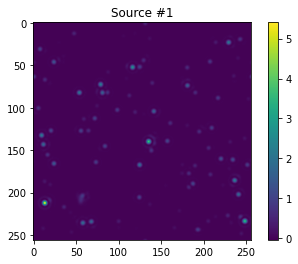

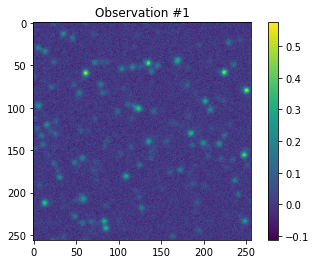

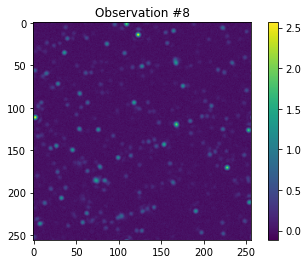

In [11]:
# View the data
print("A =\n", A0)
utils.view(S0[0,:], title='Source #1')
utils.view(Y[0,:], title='Observation #1')
utils.view(Y[-1,:], title='Observation #8')

# Joint deconvolution and blind source separation

In [12]:
# Initialize the parameters of DecGMCA
wuStrat = 3                         # warm-up Tikhonov regularization strategy
minWuIt = 100                       # minimum number of iterations at warm-up
c_wu = 0.5*np.array([1, 10])        # Tikhonov regularization hyperparameter at warm-up
c_ref = 0.5                         # Tikhonov regularization hyperparameter at refinement
cwuDec = 50                         # number of iterations for the decrease of c_wu
nStd = np.std(N)                    # noise standard deviation
useMad = False                      # use mad to estimate noise std in source space
nscales = 3                         # number of detail scales
k = 3                               # parameter of the k-std thresholding
K_max = 0.5                         # maximal L0 norm of the sources
L1 = True                           # L1 penalization
doRw = True                         # do l1 reweighing during refinement
eps = np.array([1e-2, 1e-6, 1e-4])  # stopping criteria

In [13]:
#Set the algorithm
decgmca = DecGMCA(Y, Hfft/Hfft[-1, :], n=n, wuStrat=wuStrat, minWuIt=minWuIt, c_wu=c_wu, c_ref=c_ref, cwuDec=cwuDec,
                  nStd=nStd, useMad=useMad, nscales=nscales, k=k, K_max=K_max, L1=L1, doRw=True, eps=eps, verb=verb)

In [15]:
# Run the algorithm
decgmca.run()
S = sdecgmca.S
A = sdecgmca.A

0

CA : 23.90 | NMSE: 22.32


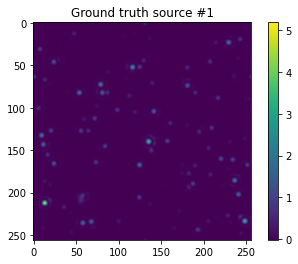

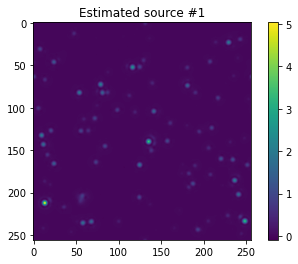

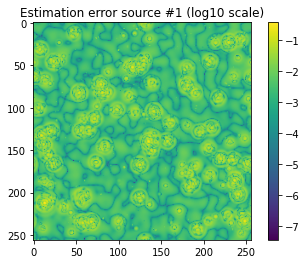

In [22]:
# Assess solution
utils.asses_solution(A0, S0c, A, S, corrPerm=True, viewData=False)
utils.view(S0c[0,:], title='Ground truth source #1')
utils.view(S[0,:], title='Estimated source #1')
utils.view(np.log10(np.abs(S0[0,:]-S[0,:])), title='Estimation error source #1 (log10 scale)')